>Authors:
>
> - Zofia Agata Lenarczyk s242916
> - Antoine Paul Louis Aubry s243253
> - Dimitrios Tsiliakidis s243204

This notebook contains the assignment 2 for the course Social Graphs and Interactions 2025.

The content of this notebook focuses on the analysis of the rock music network. It explores the rock music network through backbone and community detection, TF-IDF analysis of Wikipedia texts, and sentiment analysis to understand genre and community structure.

In [60]:
# imports
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import re
import json
from collections import defaultdict, Counter
import pandas as pd
import seaborn as sns

In the following parts of the notebook, we will refer to the rock music network created in the Assignment 1 and the *bands* folder containing the Wikipedia texts for all  artists.

In [ ]:
url_graph = "https://raw.githubusercontent.com/Azri-oss/Social_Graphs_Assignment_1/main/Assignment_1/Rock_Music_Network.graphml"

r = requests.get(url_graph)
with open("Rock_Music_Network.graphml", "wb") as f:
    f.write(r.content)

graph = nx.read_graphml("Rock_Music_Network.graphml")

In [17]:
url_bands = "https://api.github.com/repos/Azri-oss/Social_Graphs_Assignment_1/contents/Assignment_2/bands"

response_bands = requests.get(url_bands)
files_bands = response_bands.json()

# Part 1: Analyze the network

>* Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
   >- It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
   >- I would like you to include concepts like centrality and assortativity in your analysis.
   >- Use a network backbone in your analysis.
   >- In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
   >- **Note**: As I write above, an important part of the exercise consists is *selecting the right elements of the lecture* to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network. 

# Part 2: Genres and communities and plotting 


>* Write about genres and modularity.
>* Detect the communities, discuss the value of modularity in comparison to the genres.
>* Calculate the matrix $D$ and discuss your findings.
>* Plot the communities and comment on your results.


### **Question 2.1 :** Write about genres and modularity

In this question, we first aim to gather the genres of each artist into a single dictionary called *dict_mapping*. This will allow us to analyze the network through the lens of rock artists genres.

In [9]:
# Because some of the wikipedia pages have different names for a same genre, we need to do a normalization.

GENRE_NORMALIZATION = {
    "rock'n'roll": "rock and roll",
    "rock & roll": "rock and roll",
    "rock&roll": "rock and roll",
    "hip-hop": "hip hop",
    "r&b": "rhythm and blues",
    "rhythm & blues": "rhythm and blues",
    "rnb": "rhythm and blues",
    "r b": "rhythm and blues",
}
def normalize_genre_mapping(genre):
    g = genre.lower().strip()
    g = g.replace("'", "").replace('"', "")
    g = re.sub(r'\s+', ' ', g)
    return GENRE_NORMALIZATION.get(g, g)



In [ ]:
# Regex was done using LLM
def extract_genres_from_wikitext_simple(wikitext):
    """
    Only extract genres from [[...]] just after | genre = ...
    Stop capturing as soon as another field starts (|).
    """
    if not wikitext:
        return []

    genres_found = []

    # delete HTML comments
    text = re.sub(r'<!--.*?-->', '', wikitext, flags=re.DOTALL)
    # only get information after genre= and before "|"
    match = re.search(r'\|\s*genre\s*=\s*((?:.|\n)*?)(?=\n\s*\||<ref>|$|\Z)', text, re.IGNORECASE)
    # if no genre field found
    if not match:
        return []
    # get the block of text after genre=
    block = match.group(1)

    # extract content inside [[...]]
    links = re.findall(r'\[\[([^\]]+)\]\]', block) 
    for link in links:
        # part after "|" if it exists
        genre = link.split('|')[-1].strip().lower()
        # remove parentheses and content inside
        genre = re.sub(r'\(.*?\)', '', genre) 
        # to keep special characters like ä, letters and figures.
        genre = re.sub(r'[^(\w)\s&/-]', ' ', genre) 
        # normalize spaces
        genre = re.sub(r'\s+', ' ', genre).strip() 
        if genre:
            genres_found.append(genre)

    return genres_found



In [ ]:
import requests, zipfile, io, os


def genre_mapping(files_bands):
    dict = {}
    for file_info in files_bands:
        # load file content from GitHub API
        url = file_info['download_url']
        response = requests.get(url)
        data = response.json()
        # get artist name and wikitext from JSON file
        artist = data.get('page','')
        wikitext = data.get('wikitext','')
        genres = extract_genres_from_wikitext_simple(wikitext)
        normalized_genres = [normalize_genre_mapping(g) for g in genres]
        dict[artist] = normalized_genres
    return dict

dict_mapping = genre_mapping(files_bands)

Processing artist: 38_Special_(band)
Processing artist: 10_Years_(band)
Processing artist: 10cc
Processing artist: 311_(band)
Processing artist: 3_Doors_Down
Processing artist: ABBA
Processing artist: AC/DC
Processing artist: AFI_(band)
Processing artist: A_Perfect_Circle
Processing artist: Accept_(band)
Processing artist: Adam_Ant
Processing artist: Aerosmith
Processing artist: Air_Supply
Processing artist: Alanis_Morissette
Processing artist: Alice_Cooper
Processing artist: Alice_Cooper_(band)
Processing artist: Alice_in_Chains
Processing artist: Alter_Bridge
Processing artist: Ambrosia_(band)
Processing artist: America_(band)
Processing artist: Anthrax_(American_band)
Processing artist: April_Wine
Processing artist: Arcade_Fire
Processing artist: Arctic_Monkeys
Processing artist: Asia_(band)
Processing artist: Audioslave
Processing artist: Avenged_Sevenfold
Processing artist: Avril_Lavigne
Processing artist: Awolnation
Processing artist: Bachman–Turner_Overdrive
Processing artist: B

In [ ]:
def stats_genres(dict_mapping):
    count_nodes_with_genres = 0
    sum_genres = 0
    all_genres = []
    hist_genres = {}
    for genres in dict_mapping.values():
        if genres:  # only consider artists with at least one genre
            count_nodes_with_genres += 1
            # keep track of the total number of genres for all artists
            sum_genres += len(genres)
            all_genres.extend([g for g in genres])
            for g in genres:
                hist_genres[g] = hist_genres.get(g, 0) + 1
    # keep distinct genres from all_genres
    distinct_genres = set(all_genres)

    return count_nodes_with_genres, sum_genres/len(dict_mapping), len(distinct_genres), hist_genres


nodes_with_genres, average_genres, distinct_genres_count, genre_distribution = stats_genres(dict_mapping)
print("Statistics on genres:")
print("Number of nodes with genres:", nodes_with_genres)
print("Average number of genres per node:", average_genres)
print("Total distinct genres:", distinct_genres_count)

Statistics on genres:
Number of nodes with genres: 478
Average number of genres per node: 3.5348360655737703
Total distinct genres: 215


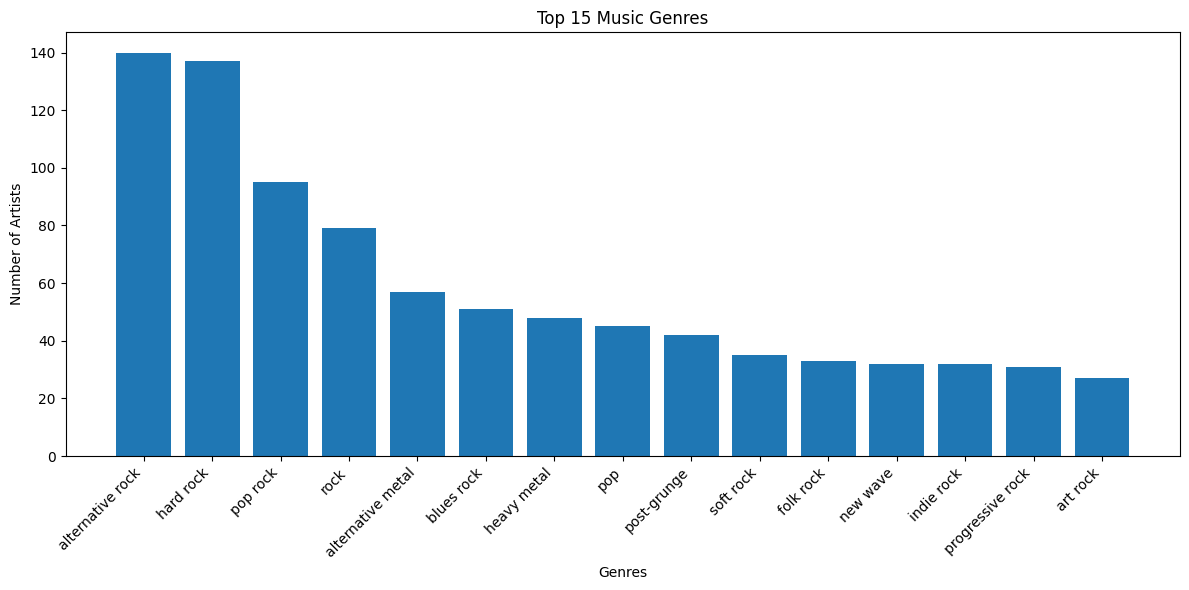

In [27]:
top_genres = sorted(list(genre_distribution.items()), key=lambda x: x[1], reverse=True)[:15]
plt.figure(figsize=(12,6))
plt.bar([x[0] for x in top_genres], [x[1] for x in top_genres])
plt.xlabel("Genres")
plt.ylabel("Number of Artists")
plt.title("Top 15 Music Genres")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

*Observation* : On average, each artist is associated with several genres. Moreover we were surprised by the large number of distinct genres. These two observations reveal that Rock Music is highly diverse, even among its most well known artists.
The histogram also shows that *alternative rock* and *hard rock* are the two predominant genres and that many subgenres of rock exist and play a significant role in the rock music sphere.

**Modularity :** The modularity represents the ability of a graph to have distinct and strong communities. Indeed, by taking into account inter-community and extra community edges, this measure indicates if the graph can be divided into communities and clusters. The following formula gives the modularity of a graph :

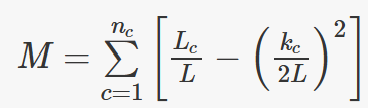

With 
* n<sub>c</sub>: number of communities
* L<sub>c</sub>: number of edges within the community C
* k<sub>c</sub>: total degree of the nodes in the community C
* L: number of edges in the graph

Thus having a better modularity (higher) means that the partition offer a better community structure. Indeed, having **M<=0** reflects a poor partition whereas having **M closer to 1** indicates a stronger community division.

### **Question 2.2 :** Detect the communities, discuss the value of modularity in comparison to the genres.

In [75]:
G_undirected = graph.to_undirected()

def remove_nodes_without_genres(G_undirected, dict_mapping):
    # Identify nodes without genres
    nodes_to_remove = [node for node in G_undirected.nodes() if dict_mapping.get(node)== []]
    print("Nodes to remove:", nodes_to_remove)
    # Remove nodes without genres from graph
    G_undirected.remove_nodes_from(nodes_to_remove)
    return G_undirected
    
remove_nodes_without_genres(G_undirected, dict_mapping)
        

Nodes to remove: ['Electric_Light_Orchestra', 'Poison_(American_band)', 'Dallas_Green_(musician)', 'The_Zombies', 'Pat_Benatar', 'The_Boxtones']


### Create communities based on the genre

For the following part we have decided to use the first listed genre to represent the genre of an artist. Indeed we assume that the genre appearing first on the Wikipedia page is usually the most representative of the artist work.

In [76]:
def label_nodes_by_genre(G_undirected, dict_mapping):
    distinct_genres = []
    for node in G_undirected.nodes():
        # Assign the first genre for the artist
        first_genre = dict_mapping.get(node)[0]
        G_undirected.nodes[node]['genre'] = first_genre
        distinct_genres.append(first_genre)
    distinct_genres = set(distinct_genres)
    return G_undirected, distinct_genres

G_undirected, distinct_genres = label_nodes_by_genre(G_undirected, dict_mapping)
print(G_undirected.nodes(data=True))
print("Distinct genres assigned:", len(distinct_genres))

[('38_Special_(band)', {'genre': 'hard rock'}), ('Jefferson_Starship', {'genre': 'rock'}), ('Peter_Frampton', {'genre': 'rock'}), ('REO_Speedwagon', {'genre': 'arena rock'}), ('Billy_Joel', {'genre': 'rock'}), ('Ted_Nugent', {'genre': 'hard rock'}), ('Lynyrd_Skynyrd', {'genre': 'southern rock'}), ('Bryan_Adams', {'genre': 'rock'}), ('Survivor_(band)', {'genre': 'rock'}), ('Huey_Lewis_and_the_News', {'genre': 'rock'}), ('Bon_Jovi', {'genre': 'hard rock'}), ('Journey_(band)', {'genre': 'arena rock'}), ('Kiss_(band)', {'genre': 'hard rock'}), ('Styx_(band)', {'genre': 'progressive rock'}), ('10cc', {'genre': 'art rock'}), ("Herman's_Hermits", {'genre': 'beat'}), ('Ringo_Starr', {'genre': 'rock'}), ('Queen_(band)', {'genre': 'rock'}), ('George_Harrison', {'genre': 'rock'}), ('Jethro_Tull_(band)', {'genre': 'progressive rock'}), ('Peter_Gabriel', {'genre': 'progressive rock'}), ('The_Police', {'genre': 'new wave'}), ('Toto_(band)', {'genre': 'arena rock'}), ('Asia_(band)', {'genre': 'progre

We lost some information because we went from 215 distinct genres to 80 but we kept the most meaninful.

In [77]:
def create_communities_by_genre(G_undirected):
    # Order nodes by genre
    sorted_nodes_by_genre = sorted(G_undirected.nodes(data=True), key=lambda x: x[1]['genre'])
    list_communities = []
    # Initialize first community
    community = [sorted_nodes_by_genre[0][0]]
    for i in range(1,len(sorted_nodes_by_genre)):
        # Test if genre changed
        if sorted_nodes_by_genre[i][1]['genre'] != sorted_nodes_by_genre[i-1][1]['genre']:
            # New community
            list_communities.append(community)
            community = [sorted_nodes_by_genre[i][0]]
        else:
            community.append(sorted_nodes_by_genre[i][0])
    list_communities.append(community)  # append last community
    return list_communities


list_communities = create_communities_by_genre(G_undirected)
print(list_communities)

[['10_Years_(band)', 'Deftones', 'Mudvayne', 'Faith_No_More', 'Staind', 'Stone_Sour', 'Godsmack', 'Chris_Cornell', 'Tool_(band)', 'Evanescence', 'System_of_a_Down', 'Primus_(band)', 'Drowning_Pool'], ['Barenaked_Ladies'], ['Stone_Temple_Pilots', 'Linkin_Park', '311_(band)', "Jane's_Addiction", 'Incubus_(band)', 'Papa_Roach', 'Morrissey', 'Pearl_Jam', 'My_Chemical_Romance', 'Alanis_Morissette', 'Foo_Fighters', 'Matchbox_Twenty', 'Garbage_(band)', 'Midnight_Oil', 'Pixies_(band)', 'Hoobastank', 'Queens_of_the_Stone_Age', 'Fuel_(band)', 'Gin_Blossoms', 'Beck', 'Cage_the_Elephant', 'Goo_Goo_Dolls', 'Third_Eye_Blind', 'Hole_(band)', 'Coldplay', 'Our_Lady_Peace', 'Awolnation', 'Twenty_One_Pilots', 'A_Perfect_Circle', 'Weezer', 'The_Smashing_Pumpkins', 'Live_(band)', 'R.E.M.', 'Ben_Folds_Five', 'The_Tragically_Hip', 'Muse_(band)', 'Highly_Suspect', 'Jimmy_Eat_World', 'Bloodhound_Gang', 'Blue_October', 'Starset', 'Flyleaf_(band)', 'Cake_(band)', 'Counting_Crows', 'Catfish_and_the_Bottlemen', 'T

In [78]:
def modularity(G_undirected, list_communities):
    modularity = 0
    L= G_undirected.number_of_edges()
    for community in list_communities:
        L_c = G_undirected.subgraph(community).number_of_edges()
        k_c = sum(dict(G_undirected.degree(community)).values())
        M_c = (L_c / L) - (k_c / (2*L))**2
        modularity += M_c
    return modularity

modularity_value = modularity(G_undirected, list_communities)
print("Modularity of the genre-based communities:", modularity_value)

Modularity of the genre-based communities: 0.09663124133677826


The modularity **M=0.09** so the partition is sub-optimal with a positive modularity but far from 1.  It suggests that there is little evidence of strong community structure based on the first genre of each Wikipedia page. It indicates that relying only on genre is insufficient to have a strong community partition.

### Create communities based on the structure of the graph

In [102]:
# Create communities based on the structure of the graph with Louvain Method
list_communities_louvain = nx.community.louvain_communities(G_undirected)
print("Number of communities:", len(list_communities_louvain))

modularity_louvain = modularity(G_undirected, list_communities_louvain)
print("Modularity of Louvain communities:", modularity_louvain)

Number of communities: 4
Modularity of Louvain communities: 0.3435752037790324


We observe we have less communities by using Louvain Method (4-5 instead of 80) and the modularity is much higher so using the structure of the graph instead of genres to create a partition.

### **Question 2.3 :** Calculate the matrix $D$ and discuss your findings

In [103]:
# Assign community labels to nodes based on the louvain partition
# This will be useful for visualization and the confusion matrix
def add_community_labels(G_undirected, partition):
    for node in G_undirected.nodes():
        for i, community in enumerate(partition):
            if node in community:
                # Assign the community label to the node
                G_undirected.nodes[node]['community'] = i
                break   
   
        
add_community_labels(G_undirected, list_communities_louvain)
print(G_undirected.nodes(data=True))

[('38_Special_(band)', {'genre': 'hard rock', 'community': 0, 'all_genres': ['hard rock', 'southern rock', 'boogie rock', 'blues rock']}), ('Jefferson_Starship', {'genre': 'rock', 'community': 0, 'all_genres': ['rock', 'hard rock', 'psychedelic rock', 'progressive rock', 'soft rock']}), ('Peter_Frampton', {'genre': 'rock', 'community': 1, 'all_genres': ['rock']}), ('REO_Speedwagon', {'genre': 'arena rock', 'community': 0, 'all_genres': ['arena rock', 'pop rock', 'hard rock', 'aor', 'blues rock']}), ('Billy_Joel', {'genre': 'rock', 'community': 1, 'all_genres': ['rock', 'soft rock']}), ('Ted_Nugent', {'genre': 'hard rock', 'community': 0, 'all_genres': ['hard rock']}), ('Lynyrd_Skynyrd', {'genre': 'southern rock', 'community': 0, 'all_genres': ['southern rock', 'blues rock', 'country rock', 'hard rock']}), ('Bryan_Adams', {'genre': 'rock', 'community': 1, 'all_genres': ['rock']}), ('Survivor_(band)', {'genre': 'rock', 'community': 0, 'all_genres': ['rock', 'arena rock', 'hard rock']}), 

In [ ]:
# In order to grasp the whole relationship between genres and communities we take into account 
# all genres of each artist instead of only the first one.
def add_all_genres_to_nodes(G_backbone, dict_mapping):
    for node in G_backbone.nodes(data=True):
        if node[0] in dict_mapping:
            node_genres = dict_mapping.get(node[0])
            node[1]['all_genres'] = node_genres
    return G_backbone

add_all_genres_to_nodes(G_undirected, dict_mapping)
print(G_undirected.nodes(data=True))

[('38_Special_(band)', {'genre': 'hard rock', 'community': 0, 'all_genres': ['hard rock', 'southern rock', 'boogie rock', 'blues rock']}), ('Jefferson_Starship', {'genre': 'rock', 'community': 0, 'all_genres': ['rock', 'hard rock', 'psychedelic rock', 'progressive rock', 'soft rock']}), ('Peter_Frampton', {'genre': 'rock', 'community': 1, 'all_genres': ['rock']}), ('REO_Speedwagon', {'genre': 'arena rock', 'community': 0, 'all_genres': ['arena rock', 'pop rock', 'hard rock', 'aor', 'blues rock']}), ('Billy_Joel', {'genre': 'rock', 'community': 1, 'all_genres': ['rock', 'soft rock']}), ('Ted_Nugent', {'genre': 'hard rock', 'community': 0, 'all_genres': ['hard rock']}), ('Lynyrd_Skynyrd', {'genre': 'southern rock', 'community': 0, 'all_genres': ['southern rock', 'blues rock', 'country rock', 'hard rock']}), ('Bryan_Adams', {'genre': 'rock', 'community': 1, 'all_genres': ['rock']}), ('Survivor_(band)', {'genre': 'rock', 'community': 0, 'all_genres': ['rock', 'arena rock', 'hard rock']}), 

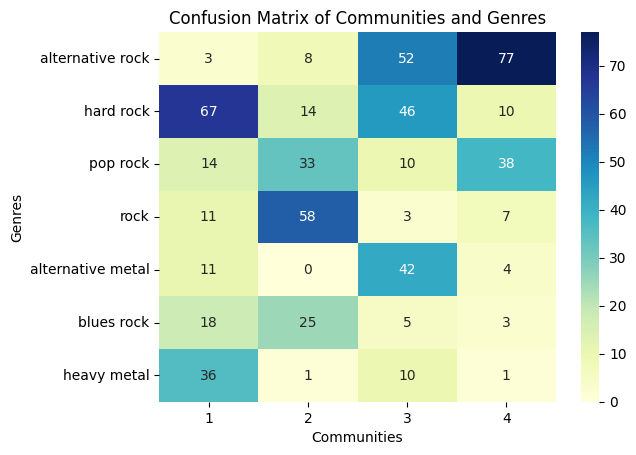

In [105]:
n_communities = len(list_communities_louvain)
n_genres = 7

def confusion_matrix_community_genres(G_backbone,top_genres,nb_communities, nb_genres):
    # Get the top genres
    top_genres_final = top_genres[:nb_genres]
    # Initialise confusion matrix
    confusion_matrix = pd.DataFrame(0, index = range(1,nb_communities+1), columns=[g for g in top_genres_final])
    
    for node in G_backbone.nodes(data=True):
        # Get all genres and community of the node   
        node_genres = node[1].get('all_genres')
        node_community = node[1].get('community')
        for node_genre in node_genres:
        # If the genre is in the top genres and community is assigned we add it to the confusion matrix
            if node_genre in top_genres_final and node_community is not None:
                confusion_matrix.loc[node_community+1,node_genre] += 1
    return confusion_matrix

top_genres_list = [genre[0] for genre in top_genres]  
confusion_matrix =confusion_matrix_community_genres(G_undirected,top_genres_list,n_communities,n_genres)

sns.heatmap(np.transpose(confusion_matrix), annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Genres")
plt.xlabel("Communities")
plt.title("Confusion Matrix of Communities and Genres")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


The Confusion Matrix changes with each run of the Louvain algorithm. However the same patterns appear at each reload. 
One community (community 2) is mostly composed of **Rock artists** and softer music like pop rock and blues rock. Another one (number 1) groups most of the heavy metal artists along with a wide part of hard rock bands, both representing **aggresive and loud music**. Community 3 seems to gather **alternative artists** (alternative rock/ alternative metal) and hard rock musicians while community 4 is primarly defined by the alternative rock artists.

Using only the fist genre for each artist would have reduced the noise from less prominent genres of artists but it may cause some relationships to be overlooked.

### **Question 2.3 :** Plot the communities and comment on your results

# Part 3: TF-IDF to understand genres and communities 


>* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
>* Calculate and visualize TF-IDF for the genres and communities.
>* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.


# Part 4: Sentiment of the artists and communities


>* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
>* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?